In [ ]:
import copy
import math
import os
import time

import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

In [ ]:
POSE_NUM = 7
SEQ_S_NUM = 10
H5_DIR = 'dataset/h5'

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import PIL.Image as Image
import cv2

#each target image correspond to a sequence of source images.
class SeqDataset(Dataset):
    def __init__(self, path):
        self.dataset = h5py.File(path, 'r')

    def __len__(self):
        return self.dataset['Train_im_t'].shape[0] * SEQ_S_NUM

    def __getitem__(self, index):
        return self.dataset["Train_im_s" + str(index % SEQ_S_NUM + 1)][index // SEQ_S_NUM] - self.dataset["Train_im_t"][index // SEQ_S_NUM], 1 if index % SEQ_S_NUM == 0 else 0

In [ ]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    i = 0
    losses = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).permute(0, 3, 1, 2)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                i += inputs.size(0)
                if (phase == "train") and (i % 100 == 0):
#                      print(i, ': ', running_loss / i, running_corrects / i)
                     losses.append(running_loss / i)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def test_model(dataloaders, model, criterion):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    i = 0
    losses = []
    
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device).permute(0, 3, 1, 2)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        i += inputs.size(0)
        if i % 100 == 0:
             losses.append(running_loss / i)


    epoch_loss = running_loss / dataset_sizes["test"]
    epoch_acc = running_corrects.double() / dataset_sizes["test"]

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # deep copy the model
 
    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return losses

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device).permute(0, 3, 1, 2)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {},  label: {}'.format(preds[j], labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)
        
def visualize_mislabel_examples(model):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    max_num_images = 6
    
    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device).permute(0, 3, 1, 2)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far == max_num_images:
                    break
                if preds[j] == labels[j]:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(max_num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {},  label: {}'.format(preds[j], labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == max_num_images:
                    model.train(mode=was_training)
                    break
                
            for j in range(inputs.size()[0]):
                if (preds[j] == 1) and (labels[j] == 1):
                    true_positive += 1
                if (preds[j] == 0) and (labels[j] == 0):
                    true_negative += 1
                if (preds[j] == 1) and (labels[j] == 0):
                    false_positive += 1
                if (preds[j] == 0) and (labels[j] == 1):
                    false_negative += 1
                    
        model.train(mode=was_training)
        
        print("true positive: ", true_positive)
        print("true negative: ", true_negative)
        print("false positive: ", false_positive)
        print("false negative: ", false_negative)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
seq_datasets = {}
dataloaders = {}
dataset_sizes = {}
for key in ["train", "val", "test"]:
    seq_datasets[key] = SeqDataset(os.path.join(H5_DIR, key + "_seq.h5"))
    dataloaders[key] = DataLoader(seq_datasets[key], batch_size=4, shuffle=True)
    dataset_sizes[key] = len(seq_datasets[key])
    print(key, " ", dataset_sizes[key])

train   7250
val   2500
test   2500


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, train_losses = train_model(dataloaders, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1055 Acc: 0.9579
val Loss: 0.0663 Acc: 0.9716

Epoch 1/4
----------
train Loss: 0.0608 Acc: 0.9794
val Loss: 0.0544 Acc: 0.9784

Epoch 2/4
----------
train Loss: 0.0510 Acc: 0.9839
val Loss: 0.0520 Acc: 0.9844

Epoch 3/4
----------
train Loss: 0.0507 Acc: 0.9840
val Loss: 0.0362 Acc: 0.9872

Epoch 4/4
----------
train Loss: 0.0289 Acc: 0.9914
val Loss: 0.0459 Acc: 0.9844

Training complete in 8m 44s
Best val Acc: 0.987200


In [ ]:
losses = test_model(dataloaders, model_ft, criterion)

Test Loss: 0.0553 Acc: 0.9816
Testing complete in 0m 8s


In [ ]:
train_losses

[0.34423352248966693,
 0.2959670329838991,
 0.28919756278395653,
 0.28617112420499324,
 0.29224359480291606,
 0.2713654098287225,
 0.2504401602356562,
 0.23161435307003558,
 0.21625094304999543,
 0.20733283285144716,
 0.2000579973174767,
 0.19510457380888208,
 0.18536638138296369,
 0.1759127407487748,
 0.1722995239847029,
 0.1705931697046617,
 0.16253304731758203,
 0.16064666314360995,
 0.16526559457783344,
 0.16753110423509499,
 0.1644097460350687,
 0.15962436590650628,
 0.15929903596184095,
 0.15756848635307202,
 0.15523703892081975,
 0.15344303843950352,
 0.15024549055077066,
 0.14849962161446456,
 0.1482162946535692,
 0.1463152551187668,
 0.14297533489320607,
 0.13969600552063638,
 0.1394202332396173,
 0.1373541461197002,
 0.13561225354611608,
 0.134141557164985,
 0.1341692973862597,
 0.13176435432425934,
 0.13068656238507873,
 0.1296250587968534,
 0.12912150954408855,
 0.12843723960689246,
 0.12655764176123127,
 0.12487658304064429,
 0.12324302503965899,
 0.12236603980716926,
 0.1

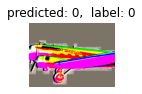

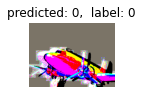

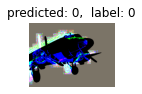

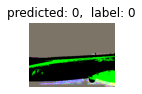

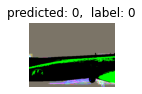

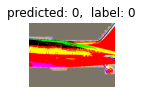

In [ ]:
visualize_model(model_ft)

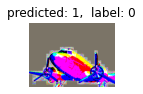

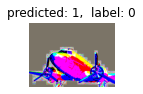

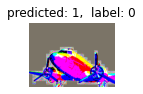

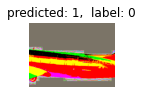

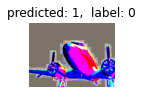

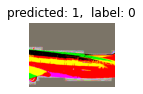

true positive:  250
true negative:  2218
false positive:  32
false negative:  0


In [ ]:
visualize_mislabel_examples(model_ft)